<a href="https://colab.research.google.com/github/Kritarth384/pytorch_learn/blob/master/pytorch_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# using our custom dataset

import torch
from torch import nn

torch.__version__

'1.13.1+cu116'

In [2]:
# setting device with gpu 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# importing data from github to our data folder 

import requests
import zipfile
from pathlib import Path

# setup path to the data folder 
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# if image folder doesn't exit ... then 
if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [4]:
# walk through the data directories using os.walk()

import os

def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza


In [6]:
# setup training and testing paths

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/train/steak/2628106.jpg
Image class: steak
Image height: 512
Image width: 512


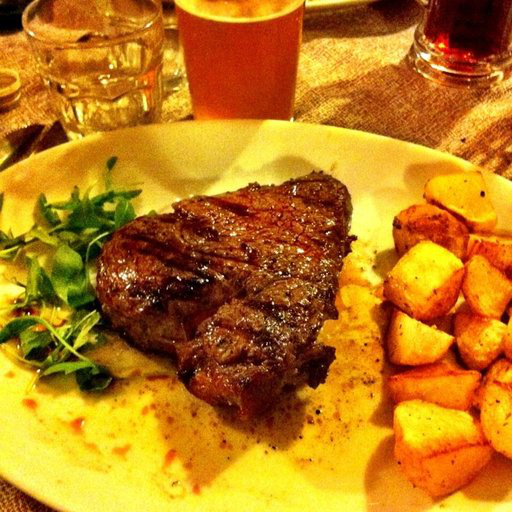

In [9]:
import random 
from PIL import Image 

# set the seed 
# random.seed(42)

# get all image paths 
image_path_list = list(image_path.glob("*/*/*.jpg"))

# get random image from the list 
random_image_path = random.choice(image_path_list)

# get image class 
image_class = random_image_path.parent.stem

# open the image 
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [14]:
# Transforming data

import torch
from torch.utils.data import DataLoader 
from torchvision import datasets, transforms 
import matplotlib.pyplot as plt

In [21]:
# write transform for image 
# transfroms.Compose is used to compile all inside steps.

data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

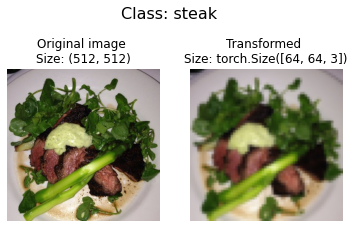

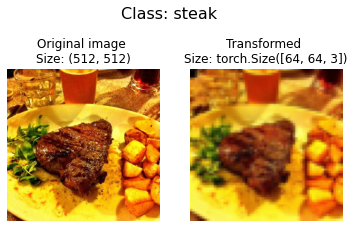

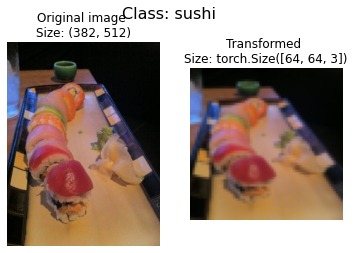

In [22]:
# tranforming the images using function below 

def plot_transformed_images(image_paths, transform, n=3, seed=42):
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  
  for image_path in random_image_paths: 
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original image \nSize: {f.size}")
      ax[0].axis("off")

      # transform image and plot it 
      # permute change the shape of image to suit matplotlib.
      # [C, H, W] ---> [H, W, C]
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

In [24]:
# use ImageFolder to create datasets in tensor 

from torchvision import datasets 

# train_data
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)
print(f"Train data :\n{train_data}\nTest data: \n {test_data}")

Train data :
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data: 
 Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [26]:
class_names = train_data.classes 
class_names

['pizza', 'steak', 'sushi']

In [27]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [28]:
len(train_data), len(test_data)

(225, 75)

In [34]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

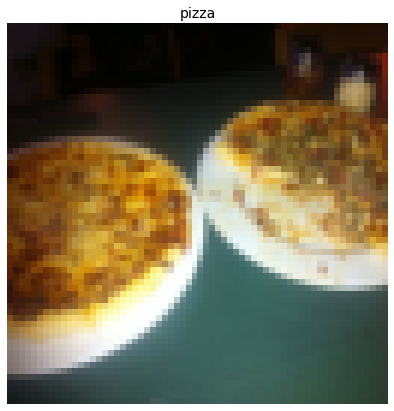

In [35]:
# now i am trying to plot single image tensor using matplotlib 

img_permute = img.permute(1, 2, 0)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14)

In [38]:
# now turn pytorch datasets into dataLoader 
# data loader is used to make them iterable so a model can go through learn 
# the relationship b/w samples and targets...(features and labels)

#  we use batch_size=1, num_workers=1...for now

from torch.utils.data import DataLoader 

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, 
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x7f9345db1d30>,
 <torch.utils.data.dataloader.DataLoader at 0x7f9345db1580>)

In [39]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [40]:
## 2nd option Loading image data with custom Dataset

import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [41]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [42]:
# creating helper function to get classnames
# we are using os.scandir .. to traverse a target directory to get classnames 

# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [43]:
# let make full function of above 
# make function to find classes in target directory 

def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  classes= sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
  # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
  class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
  return classes, class_to_idx

In [44]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [45]:
find_classes(test_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [46]:
# Now we create custom dataset to replicate ImageFolder 

# writing custom dataset class (inherits from torch.utils.data.Dataset)

from torch.utils.data import Dataset 

class ImageFolderCustom(Dataset):

  def __init__(self, targ_dir: str, transform=None) -> None:

    # get all image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))

    # setup transforms
    self.transform = transform

    # create classes and class_to_idx
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    return  len(self.paths)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_names = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_names]

    # transform if necessary
    if self.transform: 
      return self.transform(img), class_idx
    else:
      return img, class_idx

      